# `hw2`: Inference of Oxygen Saturation from Photoplethysmography


Deadline: **Monday, November 25, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [38]:
# Fill in this cell with your personal details:
# - Name: Florea Robert
# - Student ID: S201068
# - Email: robert.florea@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). You will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See Homework 1 for instructions on how to handle the dataset.

# Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that you might have seen clipped onto someone's fingertip at a hospital. It estimates **blood oxygen saturation** ($\text{SpO}_2$) by shining light through the skin at two different wavelengths (red at $\lambda = 66 \text{ nm}$ and infrared at $\lambda = 940 \text{ nm}$) and measuring how much light passes through. This measurement technique produces two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) (PPG signals) - one for each wavelength.

PPG is a non-invasive method that measures changes in blood volume in tissue using light. When your heart beats, the volume of blood in your vessels changes, which affects how much light is absorbed or reflected by the tissue. Think of it like shining a flashlight through your finger - the amount of light that passes through changes slightly with each heartbeat.

The oxygen saturation ($\text{SpO}_2$) represents the percentage of hemoglobin (the protein in red blood cells that carries oxygen) that is carrying oxygen. Mathematically, it's defined as
$$
    \text{SpO}_2 = \frac{[\text{HbO}_2]}{[\text{HbO}_2] + [\text{Hb}]},
$$
where $[\text{HbO}_2]$ is the concentration of oxygenated hemoglobin and $[\text{Hb}]$ is the concentration of deoxygenated hemoglobin. A healthy person typically has $\text{SpO}_2$ levels between 95-100%.

The PPG signal has two main components:
1. The **pulsative component** (AC) represents the changing part of the signal that varies with each heartbeat;
2. The **non-pulsative component** (DC) represents the relatively constant background signal.

Think of this like waves on the ocean: AC is like the waves on the surface, while DC is like the ocean's depth. For a cardiac cycle from time $t_1$ to $t_2$, these components are defined as
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2})
$$
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2})
$$

Since many factors can affect how light passes through tissue (like skin color, thickness, or even the presence of nail polish), oximeters use a ratio ($R$) that helps cancel out these interfering factors. This ratio compares the pulsative components at both wavelengths, normalized by their respective non-pulsative components:

$$
    R
    =
    \frac{
        \text{AC}(660 \text{ nm})/\text{DC}(660 \text{ nm})
    }{
        \text{AC}(940 \text{ nm})/\text{DC}(940 \text{ nm})
    }
$$

This ratio $R$ has a known relationship with $\text{SpO}_2$, which allows us to estimate oxygen levels without drawing blood. The different absorption patterns of oxygenated and deoxygenated hemoglobin at these two wavelengths make this estimation possible.

## Probabilistic Model

In this homework, we will build a probabilistic model that relates oxygen saturation ($\text{SpO}_2$) to the observed ratio ($R$) through five parameters:
- $\sigma^2$: variance parameter capturing measurement uncertainty,
- $\epsilon_{\text{HbO}_2}(660 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at red light,
- $\epsilon_{\text{Hb}}(660 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at red light,
- $\epsilon_{\text{HbO}_2}(940 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at infrared light,
- $\epsilon_{\text{Hb}}(940 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at infrared light.

Our model is based on the Beer-Lambert law, a fundamental principle in spectroscopy. This law states that the absorption of light by a substance in solution is proportional to its concentration. For blood at a given wavelength $\lambda$, we can write
$$
    A(\lambda) = \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(\lambda) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(\lambda).
$$

This equation tells us that the total absorption is a weighted average of the absorption by oxygenated and deoxygenated hemoglobin, where the weights are determined by the oxygen saturation level.

We then assume that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of absorptions at the two wavelengths. To account for measurement noise and other sources of uncertainty, we model $R$ as following a Normal distribution. That is, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(660 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(660 \text{ nm})
        }{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(940 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(940 \text{ nm})
        },
        \sigma^2
    \right).
$$

In this model, both the input ($\text{SpO}_2$) and the five parameters are unknown and need to be estimated from the data. However, we report below some empirical values for the absorption coefficients that should help you set reasonable priors for these parameters. Further reference values can be found at [omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [39]:
import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from scipy.optimize import minimize
from scipy.stats import norm, gamma
from scipy.signal import butter, filtfilt, resample, find_peaks

warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [41]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [42]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [43]:
f_spo2 = 2

start = 5 * 60

saturation = pd.read_csv(f'data/waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [44]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'data/waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]

t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the red and infrared PPG data on a single figure.

</div>

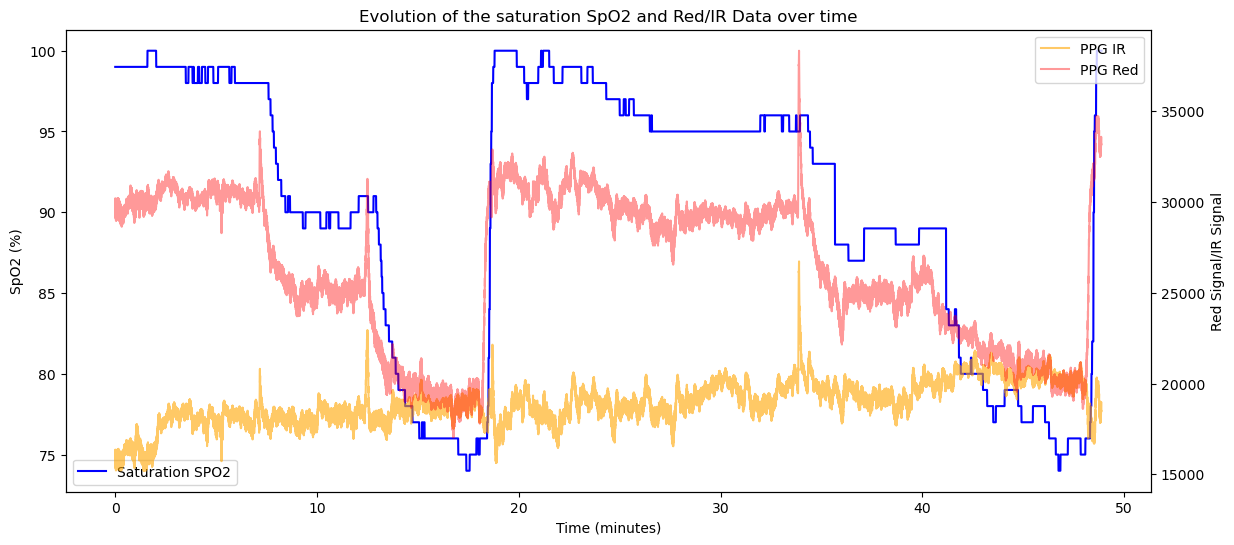

In [45]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(t_spo2, spo2, color='blue', label='Saturation SPO2')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('SpO2 (%)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(t_ppg, ir, color='orange', label='PPG IR', alpha = 0.6)
ax2.plot(t_ppg, red, color='red', label='PPG Red', alpha = 0.4)
ax2.set_ylabel('Red Signal/IR Signal')

plt.title('Evolution of the saturation SpO2 and Red/IR Data over time')
ax1.legend()
ax2.legend()
plt.show()

<div class="alert alert-success">
    
**Exercise**. Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared). Then, select a random heart cycle, defined by its span $[t_k:t_{k+1}]$, and display both PPG time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ during that heart cycle. Finally, display the distribution of the PPG time series over all heart cycles (or a subsample of a all heart cycles). 
    
</div>

<div class="alert alert-info">

**Hint**. You may want to remove the nonpulsative component $\text{DC}(\lambda)_{k}$ of the each time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ for displaying the distribution.

</div>

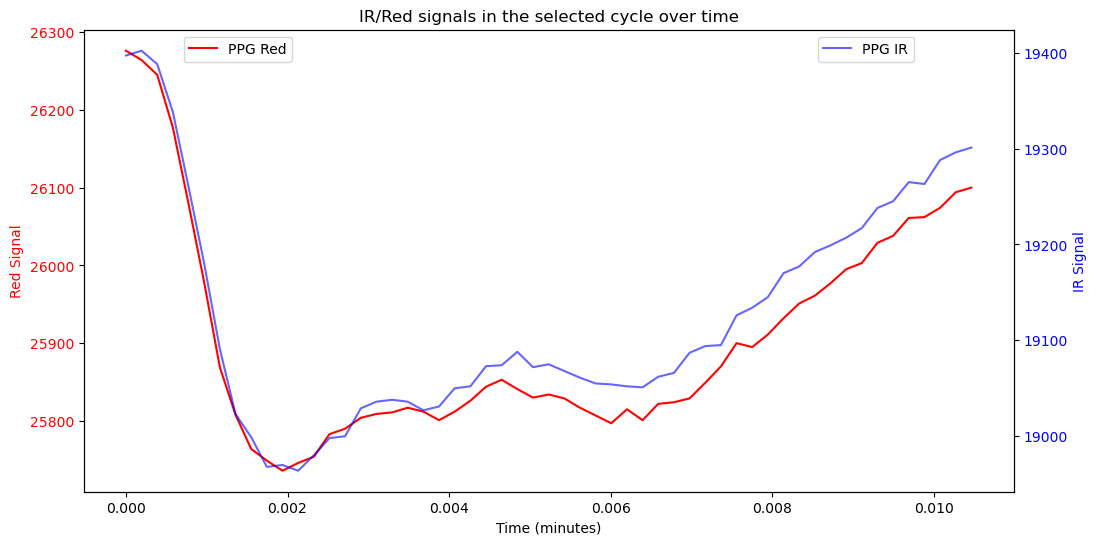

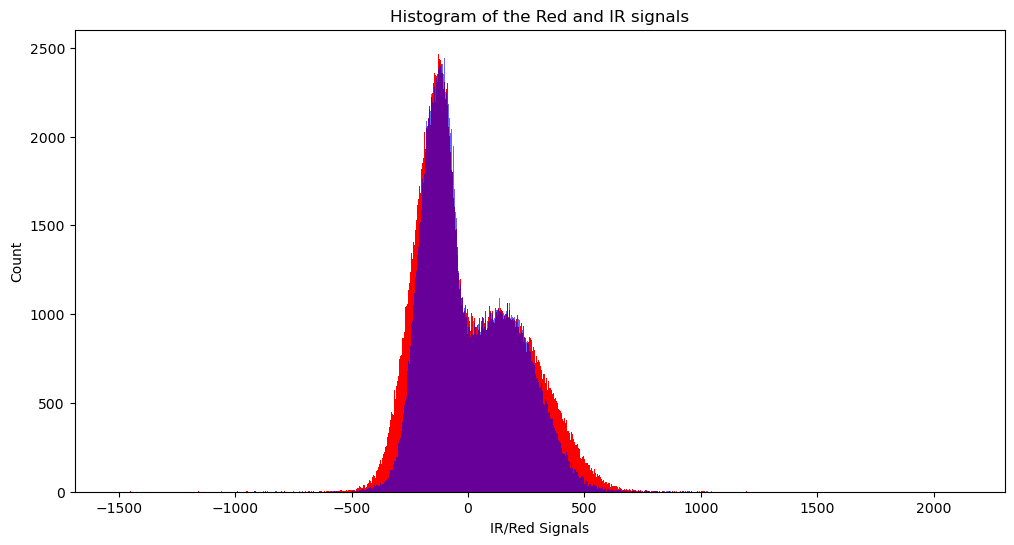

In [46]:
#choosing a random cycle
red_peaks = extract_beats(red, f_ppg)
random_cycle = np.random.RandomState(seed=24).randint(0, len(red_peaks) - 1)
start_random_cycle = red_peaks[random_cycle]
end_random_cycle = red_peaks[random_cycle + 1] - 1 # - 1 in order to stop right before the next cycle

red_random_cycle = red[start_random_cycle:end_random_cycle + 1]
ir_random_cycle = ir[start_random_cycle:end_random_cycle + 1]
t_random_cycle = np.arange(len(red_random_cycle)) / (60 * f_ppg)

#plotting both PPGs over the random cycle
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(t_random_cycle, red_random_cycle, color='red', label='PPG Red')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Red Signal', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(t_random_cycle, ir_random_cycle, color='blue', label='PPG IR', alpha = 0.6)
ax2.set_ylabel('IR Signal', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1))
plt.title('IR/Red signals in the selected cycle over time')
plt.show()

#computing distribution
#in order to remove the DC component we will mutiply each cycle by its mean
red_AC = red.copy()
ir_AC = ir.copy()
red_hist = []
ir_hist = []

counter = 0
for i in range(len(red_peaks) - 1):
    
    start = red_peaks[i]
    end = red_peaks[i + 1]
    
    red_DC_cycle = np.mean(red[start:end])
    ir_DC_cycle = np.mean(ir[start:end])

    for j in range(start, end):
        red_AC[j] = red_AC[j] - red_DC_cycle
        ir_AC[j] = ir_AC[j] - ir_DC_cycle

#excluding values that are not in any cycle
red_AC = red_AC[red_peaks[0]:red_peaks[len(red_peaks) - 1]]
ir_AC = ir_AC[red_peaks[0]:red_peaks[len(red_peaks)- 1]]

#plotting the distribution
plt.figure(figsize=(12,6))
plt.hist(red_AC, bins=1000, color='red')
plt.hist(ir_AC, bins=1000, color='blue', alpha = 0.6)
plt.title('Histogram of the Red and IR signals')
plt.ylabel('Count')
plt.xlabel('IR/Red Signals')
plt.show()


<div class="alert alert-success">
    
**Exercise**. For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.
    
</div>

In [47]:
red_ACs = []
red_DCs = []
ir_ACs = []
ir_DCs = []

for i in range(len(red_peaks) - 1):
    start = red_peaks[i]
    end = red_peaks[i + 1]
    
    DC = np.mean(red[start:end])
    red_DCs.append(DC)
    red_ACs.append(max(red[start:end]) - min(red[start:end]))
    
    DC = np.mean(ir[start:end])
    ir_DCs.append(DC)
    ir_ACs.append(max(ir[start:end]) - min(ir[start:end]))

R = []
for i in range(len(red_peaks) - 1):
    R.append((red_ACs[i] / red_DCs[i]) / (ir_ACs[i] / ir_DCs[i]))

R = resample(R, len(spo2))

<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the infered SpO2 data using the empirical law $\text{SpO2} = 110 - 25 R$. Discuss the results.

</div>

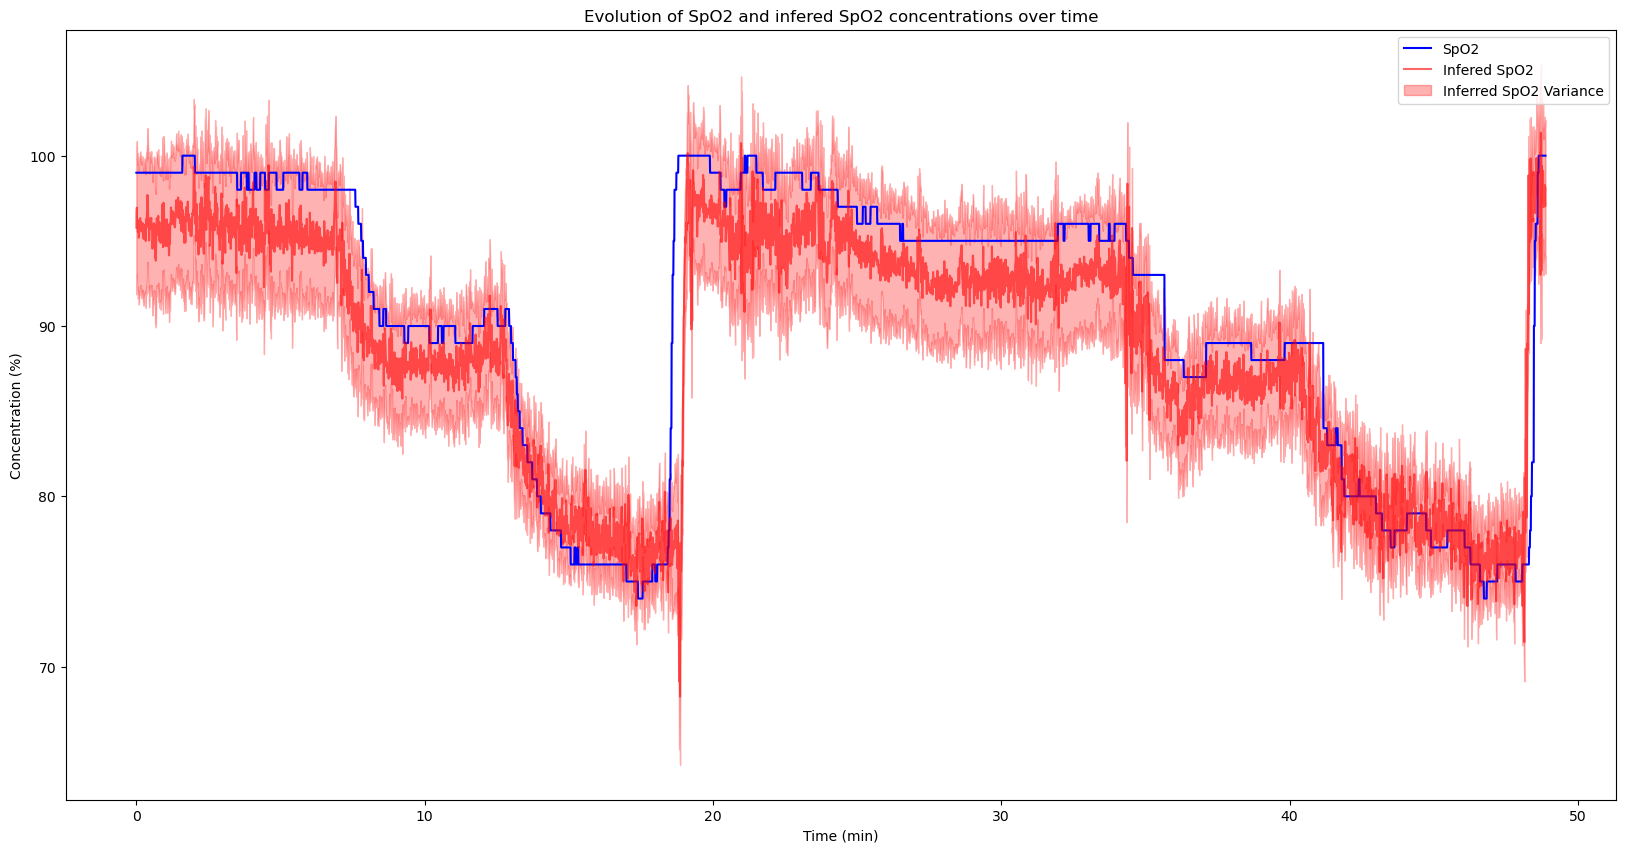

In [48]:
infered_spo2 = 110 - 25 * np.array(R)

upper_bound = infered_spo2 + (0.02 * spo2)**2
lower_bound = infered_spo2 - (0.02 * spo2)**2

plt.figure(figsize=(20, 10))
plt.title('Evolution of SpO2 and infered SpO2 concentrations over time')
plt.plot(t_spo2, spo2, color='blue', label='SpO2')
plt.plot(t_spo2[:len(infered_spo2)], infered_spo2, color='red', label='Infered SpO2', alpha = 0.6)
plt.fill_between(t_spo2, lower_bound, upper_bound, color='red', alpha=0.3, label='Inferred SpO2 Variance')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (%)')
plt.legend()
plt.show()

The overall trend of the inferred SpO2 concentration follows the observed SpO2 concentration reasonably well. For example, during rapid fluctuations (example : around 10-20 minutes and 40-50 minutes), the inferred values follow the observed values pretty accuratly, indicating that the model captures these events adequately.

However, there is a noticeable difference in variability between the observed and inferred SpO2 values. The real SpO2 (blue line) shows more distinct and sharp changes with defined flat lines, whereas the inferred SpO2 (red line) has higher variability. We can notice that the inferred values will slightly "concentrate" towards the mean of the the blue line : when the real values are high, the inferred ones are smaller and vice-versa when the real values are small. 

Another notable observation is the slight lag between the inferred SpO2 and the actual observed concentrations. During sudden changes, the inferred values tend to have a delay. This one might arise from the model not updating fast enough to follow rapid transitions.

The model seems to perform quite well in the middle zone (around 80%). As we can see, the red line tends to follows almost exactly the blue one in this part of the graph. During flat zone, the model keeps the flattness but fails to display the low increases or decreases of the real values and, as said before, during almost instanteneous variations, the model seems to have a sort of "lag".

Therefore, the model seems the capture quite well the general variations of the real values but fails to keep up with the local ones. This might tell us that our model is too simplistic and needs to be used as an approximiation of the big variations of the real values. 

## Part 2: Inference

<div class="alert alert-success">
    
**Exercise**. Write a `generate` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters. Display some realisations of the ratios ($R$) for some $\text{SpO2}_{1:T}$ data that you select.

</div>

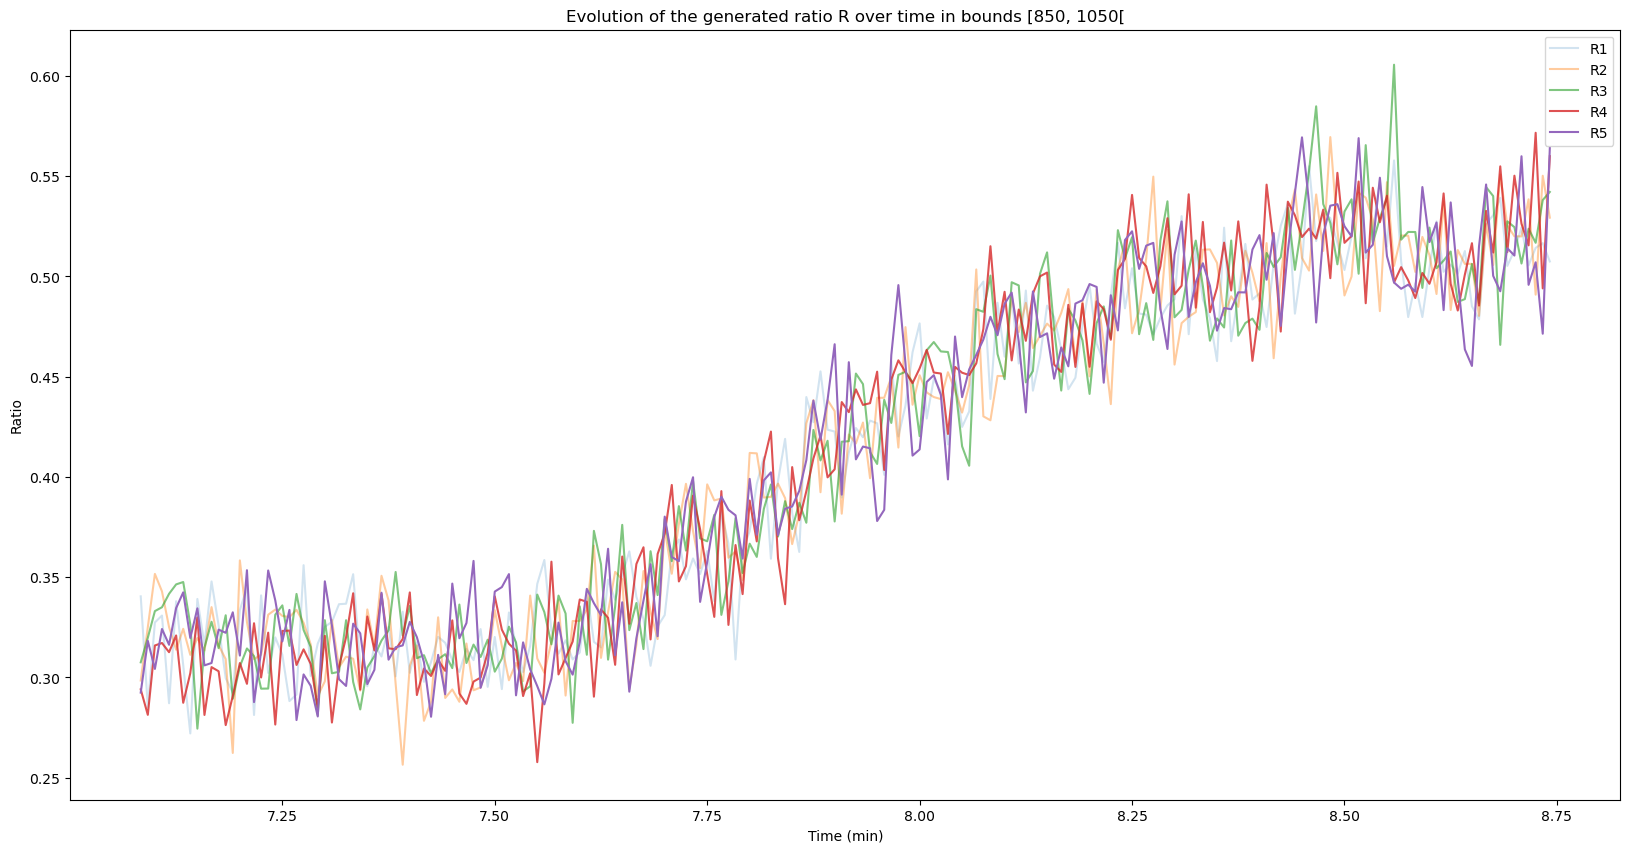

In [49]:
np.random.seed(seed=24)

def generate(SpO2_1T, sigma_squared, eps_hbo2_660=319.6, eps_hbo2_940=1214, eps_hb_660=3226.56, eps_hb_940=693.44, n=1):
    R = np.zeros((len(SpO2_1T), n))
    
    for i in range(len(SpO2_1T)):
        tmp = SpO2_1T[i]/100
        mean = (tmp * eps_hbo2_660 + (1 - tmp) * eps_hb_660)  / (tmp * eps_hbo2_940 + (1 - tmp) * eps_hb_940)
        for j in range(n):
            R[i][j] = norm.rvs(loc=mean, scale=np.sqrt(sigma_squared))
        
    return R

a = 850
b = 1050
select_spo2 = spo2[a:b]
variance = (0.02)**2

R_generated = generate(select_spo2, variance, n=5)
generated_t_R = t_spo2[a:b]

plt.figure(figsize=(20, 10))
plt.title(f'Evolution of the generated ratio R over time in bounds [{a}, {b}[')
for i in range(len(R_generated[0])):
    plt.plot(generated_t_R, R_generated[:, i], label=f'R{i+1}', alpha=0.2*(i+1))
plt.xlabel('Time (min)')
plt.ylabel('Ratio')
plt.legend()
plt.show()

<div class="alert alert-success">

**Exercise.** Write a `log_likelihood` function that takes the same arguments as `generate`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [50]:
def log_likelihood(R, SpO2_1T, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940):
    tmp = SpO2_1T/100
    mean = (tmp * eps_hbo2_660 + (1 - tmp) * eps_hb_660)  / (tmp * eps_hbo2_940 + (1 - tmp) * eps_hb_940) 
    return norm.logpdf(R, loc=mean, scale=np.sqrt(sigma_squared)).sum()

<div class="alert alert-success">
    
**Exercise**. For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).
    
</div>

In [51]:
R_subsampled = R[:len(R):200]
spo2_subsampled = spo2[:len(spo2):200]

<div class="alert alert-success">

**Exercise.** Using the observed ratios ($R$) and your `log_likelihood` function, infer the oxygen saturation data ($\text{SpO2}$) and the 5 parameters, using the maximum of likelihood estimator (MLE). Choose your parametrization and initial guess wisely. Discuss the results.

</div>

In [ ]:
#defining a negative log likelihood function that we will minimize (instead of maximizing the log likelihood)
def neg_log_likelihood(params, R):
    SpO2_1T = params[:len(R)]
    sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940 = params[len(R):]
    return -log_likelihood(R, SpO2_1T, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940)

#getting the bounds from the real ratios

real_ratios = np.genfromtxt('real_ratios.csv', delimiter=',')
real_ratios = real_ratios[1:]
red_light_hb = []
red_light_hbo2 = []
infrared_light_hb = []
infrared_light_hbo2 = []
for i in range(len(real_ratios)):
    if(real_ratios[i][0] >= 620 and real_ratios[i][0] <= 750):
        red_light_hbo2.append(real_ratios[i][1])
        red_light_hb.append(real_ratios[i][2])
    if(real_ratios[i][0] >= 780 and real_ratios[i][0] <= 1000):
        infrared_light_hbo2.append(real_ratios[i][1])
        infrared_light_hb.append(real_ratios[i][2])
    
min_hbo2_red = np.min(red_light_hbo2)
min_hb_red = np.min(red_light_hb)
min_hbo2_infrared = np.min(red_light_hbo2)
min_hb_infrared = np.min(red_light_hb)

max_hbo2_infrared = np.max(red_light_hbo2)
max_hb_infrared = np.max(red_light_hb)
max_hbo2_red = np.max(red_light_hbo2)
max_hb_red = np.max(red_light_hb)

min_spo2 = np.min(spo2) - 1
max_spo2 = 100

min_sigma_squared = np.nextafter(0, 1)
max_sigma_squared = 0.02

#we will generate random initial guesses for the parameters
best_function_value = np.inf
for i in range(500):
    #initial guess for the SpO2 values
    initial_guess = [np.random.uniform(min_spo2, max_spo2) for _ in range(len(spo2_subsampled))]
    #initial guess for the sigma squared
    initial_guess.append(np.random.uniform(min_sigma_squared, max_sigma_squared))
    #initial guess for the epsilons
    initial_guess.append(np.random.uniform(min_hbo2_red, max_hbo2_red))
    initial_guess.append(np.random.uniform(min_hbo2_infrared, max_hbo2_infrared))
    initial_guess.append(np.random.uniform(min_hb_red, max_hb_red))
    initial_guess.append(np.random.uniform(min_hb_infrared, max_hb_infrared))

    #minimizing the negative log likelihood
    result = minimize(
        neg_log_likelihood,
        initial_guess,
        args=(R_subsampled),
        method='Powell',
        bounds= len(spo2_subsampled) * [(min_spo2, max_spo2)] + 
        [(min_sigma_squared, max_sigma_squared), (min_hbo2_red, max_hbo2_red), (min_hbo2_infrared, None), (min_hb_red, max_hb_red), (min_hb_infrared, max_hb_infrared)]
    )
    
    if result.fun < best_function_value:
        best_function_value = result.fun
        best_result = result

#extracting the best parameters
MLE_infered_spo2 = best_result.x[:len(best_result.x) - 5]
best_sigma_squared, best_eps_hbo2_660, best_eps_hbo2_940, best_eps_hb_660, best_eps_hb_940 = best_result.x[len(best_result.x) - 5:]

print(f'Best function value: {best_function_value}')
print(f'Best sigma squared: {best_sigma_squared}')
print(f'Best eps_hbo2_660: {best_eps_hbo2_660}')
print(f'Best eps_hbo2_940: {best_eps_hbo2_940}')
print(f'Best eps_hb_660: {best_eps_hb_660}')
print(f'Best eps_hb_940: {best_eps_hb_940}')
print(f'Best SpO2: {MLE_infered_spo2}')

C:\Users\rober\AppData\Local\Temp\ipykernel_16680\2444819255.py:4: RuntimeWarning: invalid value encountered in sqrt
  return norm.logpdf(R, loc=mean, scale=np.sqrt(sigma_squared)).sum()


Best function value: -387.00659372464304
Best sigma squared: 6.34657872037708e-13
Best eps_hbo2_660: 275.0147530473844
Best eps_hbo2_940: 672.9870045257097
Best eps_hb_660: 5027.9016460477105
Best eps_hb_940: 2360.5351442864553
Best SpO2: [97.15608232 96.74386126 96.82548839 96.58515972 96.72785137 91.10470451
 89.97254035 90.21950412 84.68700601 76.16205552 77.32398508 80.86415834
 97.7159791  97.92863729 97.50629753 96.5910171  96.20142093 94.38671645
 95.68076665 93.84549352 96.56034828 92.99655537 88.40709604 88.17416592
 88.15814208 79.86229008 79.4490225  77.79345099 73.00005171 99.9984251 ]


The initial values were chosen in accordance with the data :
- the epsilons are generated within ranges derived from the 'real_ratios.csv' file, which contains values from the [Tabulated Molar Extinction Coefficient for Hemoglobin in Water](https://omlc.org/spectra/hemoglobin/summary.html)
- the variance is generated within the interval ]0;0.02], where the maximum value corresponds to the typical accuracy of a [Pulse oximter](https://en.wikipedia.org/wiki/Pulse_oximetry)
- the SpO₂ values have a minimum set equal to the lowest observed value of the SpO₂ data (minus one for margin) and a maximum of 100%.

To maximize the log-likelihood, we minimize the negative log-likelihood using the function `neg_log_likelihood` and the `minimize` method from SciPy. The optimization problem is bounded within the same ranges used for generating the initial values, with one exception—the maximum bound for the extinction coefficient of HbO₂ in the infrared region, which was left unbounded for better performance. The optimization involves 35 variables, consisting of 30 values for SpO₂ and 5 parameters for the epsilons and variance.

The inferred values for the epsilons are consistent with the ranges derived from the dataset (real_ratios.csv), indicating that the model appropriately fits the data. The small value of sigma squared suggests a very tight fit to the observed data, indicating that the model explains the observations well. However, such a small variance also raises concerns about overfitting, where the model might be capturing noise in addition to the true signal. Thus, it is crucial to carefully consider the quality of both the data and the model and adjust the model's precision accordingly. In our case, as discussed before, the model appears to capture the broader trends of the signal quite well. Assuming that the dataset is of high quality—which is reasonable given that it was recorded following a clear scientific protocol—a tight fit seems to be an appropriate choice.

The inferred SpO₂ values range from approximately 73.0% to 99.9%, with most values in the high 90s. This range is expected since normal SpO₂ values are typically in the high 90s. The lower values are explained by the fact that the patients were undergoing oxygen desaturation tests, which caused temporary drops in oxygen saturation.

The methodology employed, which involved 500 iterations of random initial guesses using the [Powell optimization method](https://en.wikipedia.org/wiki/Powell%27s_method), was a reasonable approach for navigating a large, potentially non-linear parameter space. The Powell method is particularly suitable for optimizing such complex likelihood surfaces, as it is derivative-free and does not require gradient information. By performing multiple optimizations with different initializations, the likelihood of finding a global optimum, rather than getting stuck in a local minimum, was significantly increased.

<div class="alert alert-success">
    
**Exercise**. Plot the distribution of ratios from the fitted model throughout the subsampled time series and compare it to the observed ratios. Then, ignore the temporal aspect and display the marginal distributions of ratios from the fitted model, along with the marginal observed distribution of ratios. Discuss the results.
        
</div>

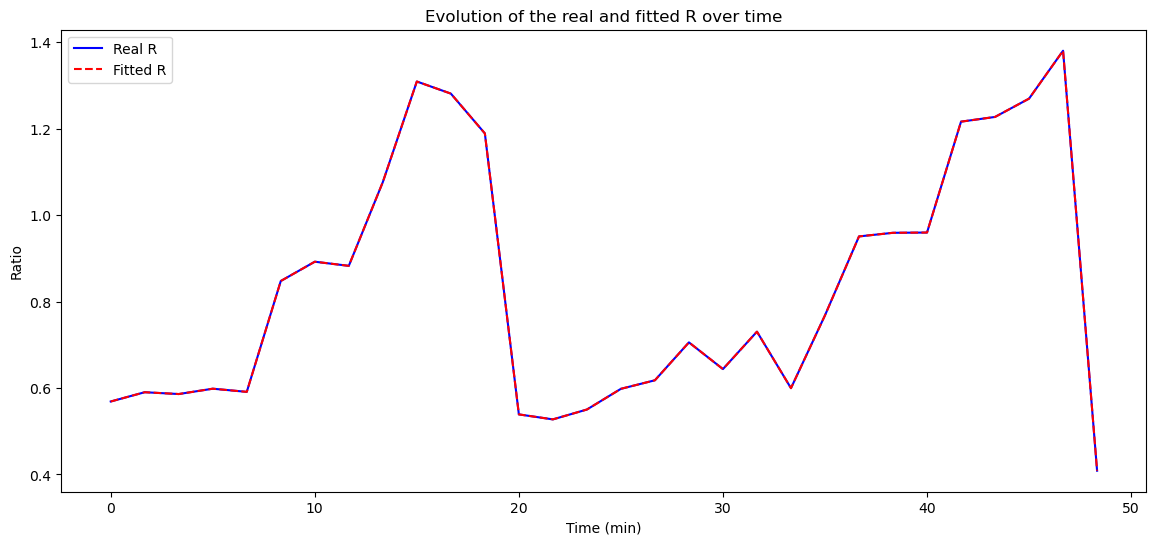

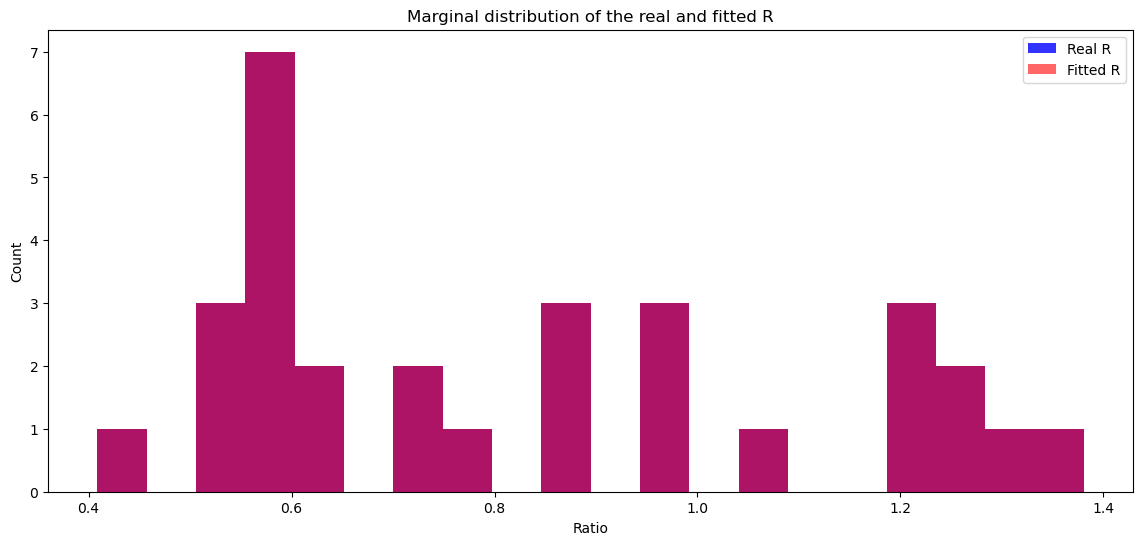

In [ ]:
fitted_R = generate(MLE_infered_spo2, best_sigma_squared, best_eps_hbo2_660, best_eps_hbo2_940, best_eps_hb_660, best_eps_hb_940)

#plotting the real and fitted R over time
plt.figure(figsize=(14, 6))
plt.plot(t_spo2[::200], R_subsampled, color='blue', label='Real R')
plt.plot(t_spo2[::200], fitted_R, linestyle='--', color='red', label='Fitted R')
plt.title('Evolution of the real and fitted R over time')
plt.xlabel('Time (min)')
plt.ylabel('Ratio')
plt.legend()
plt.show()

#plotting the marginal distribution of the real and fitted R
plt.figure(figsize=(14, 6))
plt.hist(R_subsampled, bins=20, color='blue', alpha=0.8, label='Real R')
plt.hist(fitted_R, bins=20, color='red', alpha=0.6, label='Fitted R')
plt.title('Marginal distribution of the real and fitted R')
plt.ylabel('Count')
plt.xlabel('Ratio')
plt.legend()
plt.show()

The consequence of a very low variance can be seen here. Indeed the generated ratios R fit perfectly the other ones. This, as explained before, is a sign of overift that may be problematic depending the studied case.

The holes between the bins can be explained by the fact that we don't have a lot of ratios (30), so, we won't have values for every ratio.

<div class="alert alert-success">
    
**Exercise**. Finally, plot the SpO2 values infered by MLE, together with the SpO2 values infered by the empirical model, and compare it to the SpO2 measurements. Give your observations, compare the results obtained by the two models, and discuss their limitations.
        
</div>

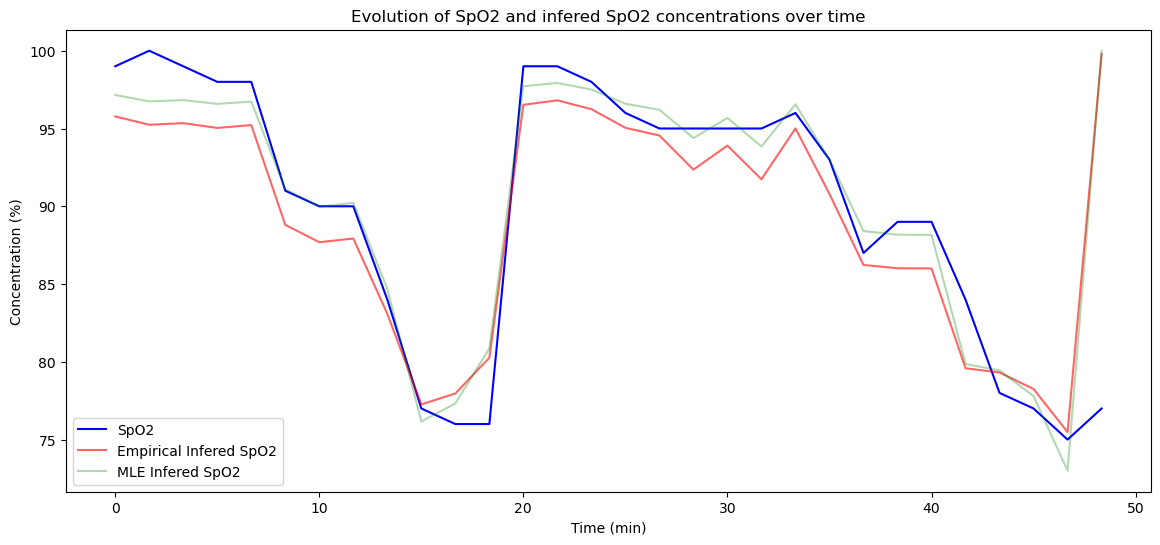

In [59]:
plt.figure(figsize=(14, 6))
plt.title('Evolution of SpO2 and infered SpO2 concentrations over time')
plt.plot(t_spo2[::200], spo2_subsampled, color='blue', label='SpO2')
plt.plot(t_spo2[::200], infered_spo2[::200], color='red', label='Empirical Infered SpO2', alpha = 0.6)
plt.plot(t_spo2[::200], MLE_infered_spo2, color='green', label='MLE Infered SpO2', alpha = 0.3)
plt.xlabel('Time (min)')
plt.ylabel('Concentration (%)')
plt.legend()
plt.show()

As shown in the plot, the MLE model generally provides a closer approximation to the true values of SpO₂, capturing the finer details more effectively compared to the empirical model. However, there are specific instances, such as the sharp decrease around 15-20 minutes, where the MLE model lags slightly behind, while the empirical model better captures this rapid transition. A similar observation can be made around 45-50 minutes, where the MLE model again struggles to keep up with the sharp decline, resulting in a less accurate approximation than the empirical model.

The MLE's tendency to overfit may cause it to struggle with sharp, sudden changes, as it tries to conform too precisely to the data, thereby missing the larger trend during these rapid movements. The empirical model, being more stable, smooths over such sudden variations, resulting in better approximations during these extreme cases. This suggests that while the MLE model excels at general inference, its performance can be outmatched by the empirical model during high-variance periods.

Overall, we can conclude that the MLE model generally offers a better fit to the observed data, particularly for gradual changes, as it is more responsive to fluctuations. However, in scenarios involving abrupt transitions, such as sudden drops, the empirical model tends to be more effective due to its inherent smoothing properties, which allow it to better approximate rapid changes without lagging.